
# Insurance Claim Prediction (Student Project)

**Objective:**  
To predict whether a building will have at least one insurance claim during its insured period based on building characteristics.

**Target Variable (`Claim`):**
- `1` → At least one claim  
- `0` → No claim  


## 1. Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


## 2. Load Dataset

In [2]:

data = pd.read_csv('Train_data.csv')
data.head()


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


## 3. Data Inspection

In [3]:

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [4]:

data.describe()


,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


## 4. Data Cleaning

In [5]:

# Check missing values
data.isnull().sum()


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [6]:

# Fill numerical missing values with median
num_cols_all = data.select_dtypes(exclude='object').columns
for col in num_cols_all:
    data[col].fillna(data[col].median(), inplace=True)


## 5. Exploratory Data Analysis (EDA)

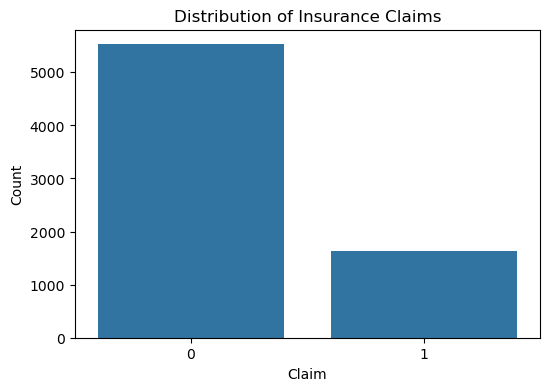

In [7]:

# Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Claim', data=data)
plt.title('Distribution of Insurance Claims')
plt.xlabel('Claim')
plt.ylabel('Count')
plt.show()


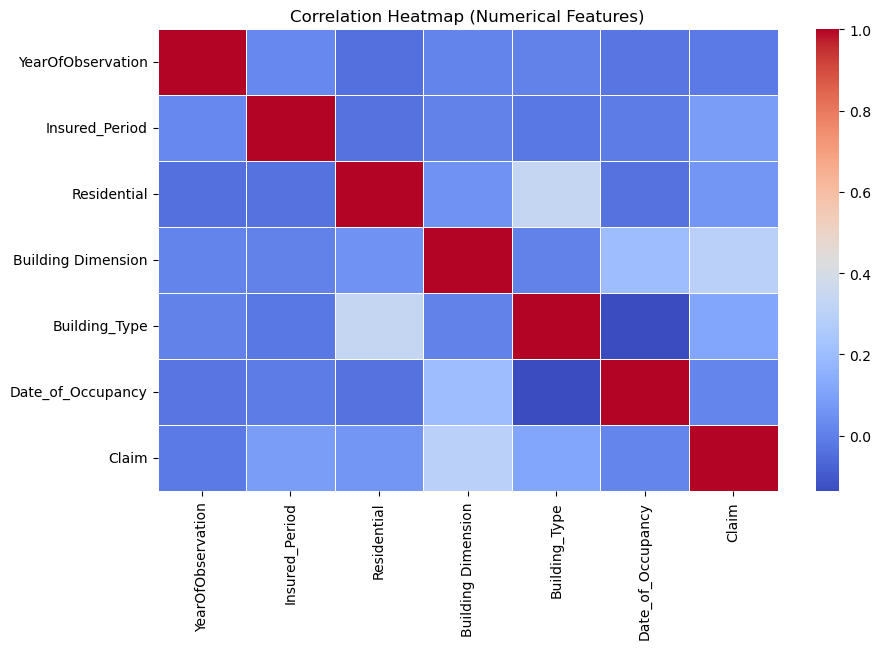

In [8]:

# Correlation heatmap for numerical features
plt.figure(figsize=(10,6))
corr = data.select_dtypes(exclude='object').corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()


## 6. Feature and Target Separation

In [9]:

X = data.drop('Claim', axis=1)
y = data['Claim']


## 7. Train-Test Split

In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 8. Identify Feature Types

In [11]:

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

cat_cols, num_cols


(Index(['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden',
        'Settlement', 'NumberOfWindows', 'Geo_Code'],
       dtype='object'),
 Index(['YearOfObservation', 'Insured_Period', 'Residential',
        'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
       dtype='object'))

## 9. Data Preprocessing

In [12]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


## 10. Model 1: Logistic Regression

In [13]:

log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_probs))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.58      0.19      0.28       327

    accuracy                           0.78      1432
   macro avg       0.69      0.57      0.58      1432
weighted avg       0.75      0.78      0.74      1432

ROC-AUC: 0.6863520002214012


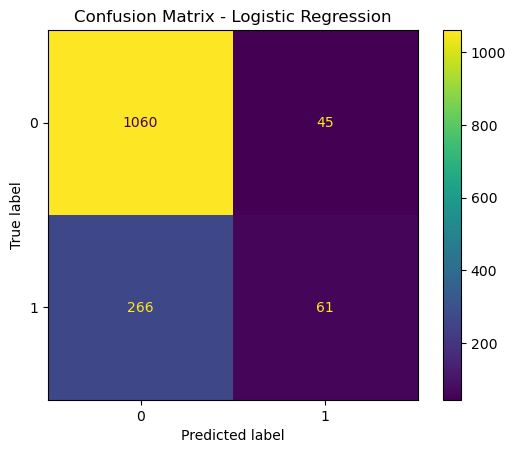

In [14]:

# Confusion Matrix - Logistic Regression
cm_log = confusion_matrix(y_test, log_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## 11. Model 2: Random Forest

In [19]:

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

rf_model = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.56      0.17      0.27       327

    accuracy                           0.78      1432
   macro avg       0.68      0.57      0.57      1432
weighted avg       0.74      0.78      0.73      1432

ROC-AUC: 0.6721615675204451


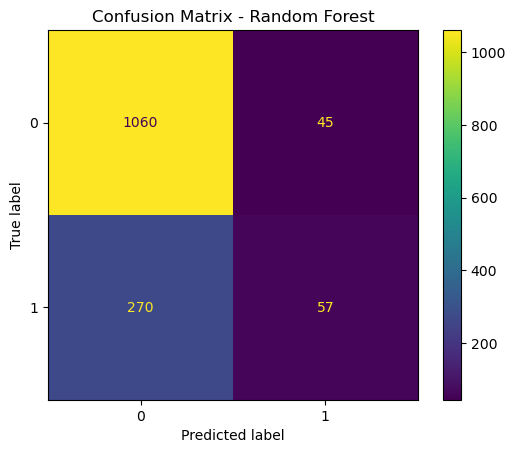

In [16]:

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()


## 12. Model Comparison

In [17]:

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'ROC_AUC': [
        roc_auc_score(y_test, log_probs),
        roc_auc_score(y_test, rf_probs)
    ]
})

results


,Model,ROC_AUC
0,Logistic Regression,0.686352
1,Random Forest,0.672162


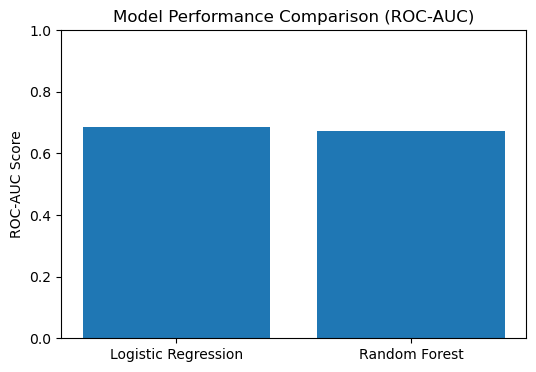

In [18]:

# ROC-AUC Comparison Bar Chart
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['ROC_AUC'])
plt.title('Model Performance Comparison (ROC-AUC)')
plt.ylabel('ROC-AUC Score')
plt.ylim(0,1)
plt.show()



## 13. Conclusion

In this project, we tried to predict whether a building is likely to have an insurance claim or not using information about the building. We first cleaned the data and looked at it to understand how the claims are distributed. After that, we trained two different machine learning models.

Both models were able to make predictions, but the Random Forest model performed better than the Logistic Regression model. This means it was more accurate in identifying buildings that may have insurance claims.

Overall, this project shows that by using building information and machine learning, insurance companies can better understand risk and make smarter decisions. This can help them prepare for possible claims and manage insurance costs more effectively.